In [76]:
from dotenv import load_dotenv
load_dotenv()

Python-dotenv could not parse statement starting at line 4


True

In [77]:
import pickle
import tiktoken
import pandas as pd
import numpy as np

from llama_index import Document
from llama_index.node_parser import SimpleNodeParser
from llama_index.indices.postprocessor import LLMRerank

from langchain.chat_models import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter, Language
from llama_index import LLMPredictor, GPTVectorStoreIndex, PromptHelper, ServiceContext

In [114]:
from IPython.display import display, Markdown
import ipywidgets as widgets


In [78]:
with open("../algovate/data/documents.pkl", "rb") as f:
    lc_documents = pickle.load(f)

enc = tiktoken.get_encoding("cl100k_base")


In [112]:
def evaluate_dataframe_answer(df):
    # Add right_or_wrong column if it doesn't exist
    if 'right_or_wrong' not in df.columns:
        df['right_or_wrong'] = ''

    # Widgets
    button_right = widgets.Button(description="Right")
    button_wrong = widgets.Button(description="Wrong")
    button_partial = widgets.Button(description="partial")
    out = widgets.Output()

    # Starting index
    index = [0]  # Use list to allow mutation inside functions

    def display_row(row):
        """
        Display the row data in markdown
        """
        with out:
            display(Markdown(f"**Question**: {row['question']}"))
            display(Markdown(f"**Answer**: {row['answer']}"))
            display(Markdown(f"**Result**: {row['result']}\n"))

    def on_button_right_clicked(b):
        """
        Update right_or_wrong column with 'right' and go to next row
        """
        df.at[index[0], 'right_or_wrong'] = 'right'
        index[0] += 1
        out.clear_output()
        if index[0] < len(df):
            display_row(df.iloc[index[0]])

    def on_button_wrong_clicked(b):
        """
        Update right_or_wrong column with 'wrong' and go to next row
        """
        df.at[index[0], 'right_or_wrong'] = 'wrong'
        index[0] += 1
        out.clear_output()
        if index[0] < len(df):
            display_row(df.iloc[index[0]])

    def on_button_partial_clicked(b):
        """
        Update right_or_wrong column with 'partial' and go to next row
        """
        df.at[index[0], 'right_or_wrong'] = 'partial'
        index[0] += 1
        out.clear_output()
        if index[0] < len(df):
            display_row(df.iloc[index[0]])

    button_right.on_click(on_button_right_clicked)
    button_wrong.on_click(on_button_wrong_clicked)
    button_partial.on_click(on_button_partial_clicked)

    display(out)
    display(button_right, button_wrong, button_partial)

    # Start by displaying the first row
    display_row(df.iloc[0])

### Markdown Splitter

<Axes: >

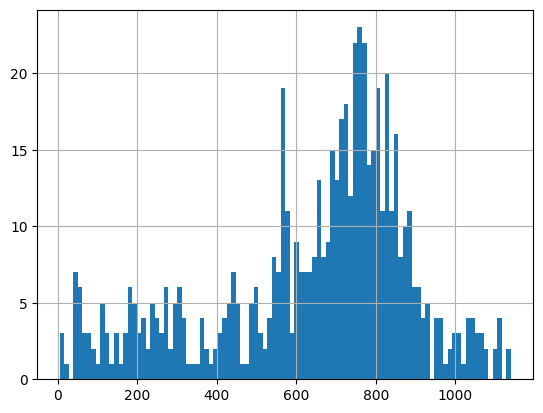

In [79]:
splitter = RecursiveCharacterTextSplitter(chunk_size=(700*5), chunk_overlap=100)
split_docs = splitter.split_documents(lc_documents)
lens = []
for doc in split_docs:
    d = doc.page_content
    lens.append(
        len(enc.encode(d))
    )
pd.Series(lens).hist(bins=100)

In [67]:
splitter_markdown = RecursiveCharacterTextSplitter.from_language(language=Language.MARKDOWN, chunk_size=(700*5), chunk_overlap=100)
#(chunk_size=1000, chunk_overlap=100, language=Language.MARKDOWN)

split_docs_markdown = splitter_markdown.split_documents(lc_documents)

lens_markdown = []
for doc in split_docs_markdown:
    d = doc.page_content
    lens_markdown.append(
        len(enc.encode(d))
    )

# pd.Series(lens_markdown).hist(bins=100)

In [68]:
len(lens_markdown), len(lens)

(779, 611)

### Node Parser

In [105]:
# load the ground truths
with open("/home/marshath/play/chainlink/algovate/algovate/data/ground_truths.pkl", "rb") as f:
    ground_truths = pickle.load(f)

df = pd.DataFrame(ground_truths)

In [80]:
documents = []
for doc in lc_documents:
    documents.append(
        Document(
            text=doc.page_content, 
            extra_info=doc.metadata
        )
    )

parser = SimpleNodeParser(
    text_splitter=RecursiveCharacterTextSplitter.from_language(
                            language=Language.MARKDOWN, 
                            chunk_size=(700*5), 
                            chunk_overlap=100
    )
) 
nodes = parser.get_nodes_from_documents(documents)

In [81]:
llm_predictor = LLMPredictor(
    llm=ChatOpenAI(
        temperature=0, 
        model_name="gpt-3.5-turbo"
    )
)

In [84]:
service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor, node_parser=parser)
reranker = LLMRerank(choice_batch_size=5, top_n=3, service_context=service_context)

In [107]:
index = GPTVectorStoreIndex.from_documents(
    documents=documents, 
    service_context=service_context
)

query_engine = index.as_query_engine(
    similarity_top_k=10,
    node_postprocessors=[reranker],
)

In [109]:
df2 = df.copy()
for i, gt in df2.iterrows():
    try:
        df2.loc[i, "result"] = query_engine.query(gt.question)
    except Exception as e:
        print(e)
        df2.loc[i, "result"] = "ERROR"

This model's maximum context length is 4097 tokens. However, your messages resulted in 4429 tokens. Please reduce the length of the messages.
This model's maximum context length is 4097 tokens. However, your messages resulted in 5243 tokens. Please reduce the length of the messages.
This model's maximum context length is 4097 tokens. However, your messages resulted in 5063 tokens. Please reduce the length of the messages.
This model's maximum context length is 4097 tokens. However, your messages resulted in 4328 tokens. Please reduce the length of the messages.
invalid literal for int() with base 10: 'Both documents are relevant'
list index out of range


In [110]:
df2

,question,answer,result
0,give me a sample solidity contract to use Chai...,// SPDX-License-Identifier: MIT\npragma solidi...,Here is a sample Solidity contract to use Chai...
1,give me a sample solidity contract to use Chai...,// SPDX-License-Identifier: MIT\npragma solidi...,"For this example, you can use the `VRFD20.sol`..."
2,give me a sample solidity contract to use NFT ...,// SPDX-License-Identifier: MIT\npragma solidi...,Here is a sample Solidity contract to use NFT ...
3,give me a sample solidity contract to use Proo...,// SPDX-License-Identifier: MIT\npragma solidi...,Here is a sample Solidity contract to use Proo...
4,Give sample code for an example contract that ...,// SPDX-License-Identifier: MIT\npragma solidi...,```\n// SPDX-License-Identifier: MIT\npragma s...
5,Give code examples to demonstrate how to deplo...,// SPDX-License-Identifier: MIT\npragma solidi...,Solidity and Vyper code examples are provided ...
6,Write code to show how to use web3.js to retri...,/**\n * THIS IS EXAMPLE CODE THAT USES HARDCOD...,Here is an example code that uses web3.js to r...
7,What is the LINK token contract on ethereum ma...,0x514910771AF9Ca656af840dff83E8264EcF986CA,The LINK token contract on Ethereum mainnet ha...
8,What is the chainlink price feed address for 1...,0x72AFAECF99C9d9C8215fF44C77B94B99C28741e8,ERROR
9,What is the proof of reserve address for Cache...,Not provided in the context,The context information states the proof of re...


In [115]:
evaluate_dataframe_answer(df2)

Output()

Button(description='Right', style=ButtonStyle())

Button(description='Wrong', style=ButtonStyle())

Button(description='partial', style=ButtonStyle())